<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivos/blob/master/notebooks/3b_indice_inverso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Búsqueda de documentos por índice inverso
En esta libreta desarrollaremos un buscador de documentos usando índice inverso

## Búsqueda de documentos por palabras
Primero vamos a ver cómo hacer búsqueda de documentos por palabras

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

Descargamos el conjunto de datos _20 newsgroups_

In [0]:
db = fetch_20newsgroups(remove=('headers','footers','quotes'))

Vemos cómo luce un documento

In [3]:
print(db.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Concatenamos todos los documentos en una sola cadena y la partimos en palabras para crear el vocabulario

In [4]:
texto = ' '.join(db.data) 
palabras = [p for p in texto.split() if p.isalnum()]
print(palabras[:10])

['I', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me']


Indizamos las palabras y contamos sus frecuencias en el conjunto

In [0]:
from collections import Counter

vocab = Counter()
for p in palabras:
    vocab[p] += 1

Graficamos los histogramas de frecuencias de palabras en el conjunto

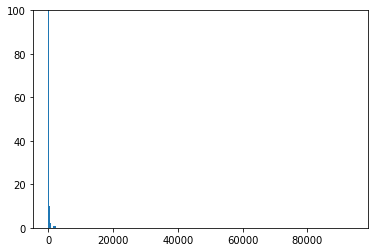

In [6]:
hist = np.array(list(vocab.values()))
plt.hist(hist, bins=10000)
plt.ylim([0,100])
plt.show()

Importamos la biblioteca NLTK y definimos nuestro analizador léxico y lematizador

In [7]:
import nltk
nltk.download(['punkt','averaged_perceptron_tagger','wordnet'])
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

def doc_a_tokens(doc):
  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))

  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Guardamos el conjunto preprocesado como una lista de cadenas, una por documento

In [0]:
corpus = []
for d in db.data:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  tokens = doc_a_tokens(d)
  corpus.append(' '.join(tokens))

Obtenemos las bolsas de palabras de los documentos preprocesados usando la clase `CountVectorizer` de scikit-learn

In [0]:
v = CountVectorizer(corpus, stop_words='english', max_features=5000, max_df=0.8)
bolsas = v.fit_transform(db.data)

Definimos la clase para el índice inverso con un método para recuperar los documentos que contienen una lista de palabras

In [0]:
class IndiceInverso:
  def  __getitem__(self, idx):
    return self.ifs[idx]

  def recupera(self, l):
    docs = Counter()
    for (i,_) in l:
      docs.update(self.ifs[i])

    return docs

  def from_csr(self, csr):
    self.ifs = [[] for _ in range(csr.shape[1])]
    coo = csr.tocoo()    
    for i,j,v in zip(coo.row, coo.col, coo.data):
      self.ifs[j].append(i)

Instanciamos nuestra clase `IndiceInverso` y creamos la estructura a partir de nuestras bolsas de palabras

In [0]:
ifs = IndiceInverso()
ifs.from_csr(bolsas)

Definimos una función que convierta de arreglos dispersos CSR a listas de listas

In [0]:
def csr_to_ldb(csr):
  ldb = [[] for _ in range(csr.shape[0])]
  coo = csr.tocoo()    
  for i,j,v in zip(coo.row, coo.col, coo.data):
    ldb[i].append((j, v))

  return ldb

Generamos algunas consultas y calculamos sus bolsas de palabras

In [0]:
consultas = []
for c in ['nasa space mission satellite','government crime enforcement security']:
  tokens = doc_a_tokens(c)
  consultas.append(' '.join(tokens))

bc = v.transform(consultas)
cl = csr_to_ldb(bc)

Usamos el índice inverso para recuperar los documentos que contienen las palabras de la primera consultas ordenados por coincidencias y visualizamos el primer documento recuperado

In [14]:
recs = ifs.recupera(cl[0])
top = recs.most_common()[0]
print(db.data[top[0]])

Archive-name: space/new_probes
Last-modified: $Date: 93/04/01 14:39:17 $

UPCOMING PLANETARY PROBES - MISSIONS AND SCHEDULES

    Information on upcoming or currently active missions not mentioned below
    would be welcome. Sources: NASA fact sheets, Cassini Mission Design
    team, ISAS/NASDA launch schedules, press kits.


    ASUKA (ASTRO-D) - ISAS (Japan) X-ray astronomy satellite, launched into
    Earth orbit on 2/20/93. Equipped with large-area wide-wavelength (1-20
    Angstrom) X-ray telescope, X-ray CCD cameras, and imaging gas
    scintillation proportional counters.


    CASSINI - Saturn orbiter and Titan atmosphere probe. Cassini is a joint
    NASA/ESA project designed to accomplish an exploration of the Saturnian
    system with its Cassini Saturn Orbiter and Huygens Titan Probe. Cassini
    is scheduled for launch aboard a Titan IV/Centaur in October of 1997.
    After gravity assists of Venus, Earth and Jupiter in a VVEJGA
    trajectory, the spacecraft will arrive a

Repetimos el proceso anterior para la segunda consulta

In [15]:
recs = ifs.recupera(cl[1])
top = recs.most_common()[0]
print(db.data[top[0]])

This document is in the anonymous ftp directory at NIST.  Looks to me
like the other shoe has dropped.

	Jim Gillogly
	Trewesday, 25 Astron S.R. 1993, 17:00

-------------------

Note:  This file will also be available via anonymous file
transfer from csrc.ncsl.nist.gov in directory /pub/nistnews and
via the NIST Computer Security BBS at 301-948-5717.
     ---------------------------------------------------

                         THE WHITE HOUSE

                  Office of the Press Secretary

_________________________________________________________________

For Immediate Release                           April 16, 1993


                STATEMENT BY THE PRESS SECRETARY


The President today announced a new initiative that will bring
the Federal Government together with industry in a voluntary
program to improve the security and privacy of telephone
communications while meeting the legitimate needs of law
enforcement.

The initiative will involve the creation of new products to
ac

## Búsqueda de documentos similares
Ahora vamos a realizar búsquedas de documentos similares a un documento de consulta.

Primero tomamos 1 documento que sirva de consulta y lo visualizamos

In [16]:
dc = db.data[0]
print(dc)

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


Obtenemos su bolsa

In [0]:
tokens = doc_a_tokens(dc)
bolsa_dc = v.transform([' '.join(tokens)])

Definimos una función para hacer búsqueda por fuerza bruta dada una función de distancia o similitud

In [0]:
def fuerza_bruta(base, consulta, fd):
  medidas = np.zeros(base.shape[0])
  for i,x in enumerate(base):
    medidas[i] = fd(consulta, x)

  return medidas

Definimos la función para la similitud coseno

In [0]:
def similitud_coseno(x, y):
  x = x.toarray()[0]
  y = y.toarray()[0]
  return (x @ y) / (np.sqrt(x @ x) * np.sqrt(y @ y))

In [20]:
sims = fuerza_bruta(bolsas[1:], bolsa_dc, similitud_coseno)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [21]:
print('Similitud máxima es {0} de documento {1}'.format(np.nanmax(sims), np.nanargmax(sims)+ 1))

Similitud máxima es 0.43759497449368373 de documento 8266


Revisamos documento más similar

In [22]:
print(db.data[np.nanargmax(sims) + 1])


Definitely!

Safety is an important criterium for me when buying a car. I won't buy a 
small car like a Civic or whatever.

Great = Safety + Handling + Speed  -  for me

Seems to me that you would be more "dead" in a small car than a large car 
after an accident.


Definimos la distancia euclidiana

In [0]:
def distancia_euclidiana(x, y):   
  x = x.toarray()[0]
  y = y.toarray()[0]
  return np.sqrt(np.sum((x - y)**2))

Repetimos el proceso anterior con la distancia euclidiana

In [24]:
euclids = fuerza_bruta(bolsas[1:], bolsa_dc, distancia_euclidiana)
print('Distancia mínima es {0} de documento {1}'.format(np.nanmin(euclids), np.nanargmin(euclids) + 1))

Distancia mínima es 6.4031242374328485 de documento 6581


Visualizamos el documento

In [25]:
print(db.data[np.nanargmin(euclids) + 1])


     There's only one car that really fits your needs. It's spelled:


Hacemos lo mismo para la similitud de Jaccard y MinMax

In [0]:
def similitud_jaccard(x, y):
  x = x.toarray()[0]
  y = y.toarray()[0]
  inter = np.count_nonzero(x * y)
  return inter / (np.count_nonzero(x) + np.count_nonzero(y) - inter)

def similitud_minmax(x, y):
  x = x.toarray()[0]
  y = y.toarray()[0]
  c = np.vstack((x,y))
  mn = np.sum(np.min(c, axis=0))
  mx = np.sum(np.max(c, axis=0))
  return mn / mx

Calculamos las similitudes con todos los documentos

In [27]:
js = fuerza_bruta(bolsas[1:], bolsa_dc, similitud_jaccard)
mms = fuerza_bruta(bolsas[1:], bolsa_dc, similitud_minmax)
print('Similitud de Jaccard máxima es {0} de documento {1}'.format(np.nanmax(js), np.nanargmax(js) + 1))
print('Similitud de MinMax máxima es {0} de documento {1}'.format(np.nanmax(mms), np.nanargmax(mms) + 1))

Similitud de Jaccard máxima es 0.125 de documento 8924
Similitud de MinMax máxima es 0.11267605633802817 de documento 6997


Visualizamos documento con mayor similitud de Jaccard

In [28]:
print(db.data[np.nanargmax(js) + 1])

I am interested to know if there is any Pontiac e-mail car clubs out
there?  Has anyone started one, or is anybody thinking about starting one.
Thanks for any info you can give me


Lo mismo para la similitud MinMax

In [29]:
print(db.data[np.nanargmax(mms) + 1])


Perhaps instead of this silly argument about what backup lights
are for, couldn't we agree that they serve the dual purpose of
letting people behind your car know that you have it in reverse
and that they can also light up the area behind your car while
you're backing up so you can see?

Backup lamps on current models are much brighter than they used
to be on older cars. Those on my Taurus Wagon are quite bright
enough to illuminate a good area behind the car, and they're 
MUCH brighter than those on my earlier cars from the 60s and 70s. 

Insofar as Vettes having side backup lights, look at a '92 or '93
model (or perhaps a year or two earlier too) and you'll see
red side marker lamps and white side marker lamps both near the
car's hindquarters.  Those aren't just white reflectors. 


## Ejercicio
+ Usa el índice inverso para acelerar el proceso de búsqueda para la similitud de Jaccard, MinMax y Coseno